# Introduction
The goal is to implement an item-to-item collaborative filtering, e.g., for a given item, which other items share the
same viewers). In other words, given an item id, which other items are most strongly related based
on viewership.

*Data*
- EventId -- A unique identifier for this event in the form of a SHA256 hash
- MediaId -- A unique identifier for watched Media items as an integer
- UserId -- A unique identifier for a user-account as an integer
- Timestamp -- A Unix/POSIX Epoch time representation of the client-side time
- DateTime -- An ISO-8601 formatted representation of the client-side time
- EventType -- The type of view-event send to the server
-- waypoint -- denoting a 30 seconds watched interval
-- streamstart -- denoting the start of a stream
-- streamstop -- denoting a client-initiated stop of stream
-- streamend -- denoting the end of the media item is reached, should occur once for each user-
item combination

In [1]:
import gzip
import joblib
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import timeit

FONTSIZE = 15
LOCAL_PATH = 'data/'
FILE_PATH = LOCAL_PATH + "noisy_mock_events.gz"

# Process stream events
The following steps were done to process the data:
- Read data and store as pd.DataFrame.
- Group by user and items, aggregate the streamlength.
- Filter streams that don't contain StreamStart and StreamStop, because StreamStop is related to user interaction.  

In [4]:
# get keys
with gzip.open(FILE_PATH, "r") as events_file:
    while line := events_file.readline():
        event = json.loads(line)
        # discard EventId
        keys = list(event.keys())[1:]
        break

# get values
collab_raw_timeseries = []

start_time = timeit.default_timer()

with gzip.open(FILE_PATH, "r") as events_file:
    while line := events_file.readline():
        event = json.loads(line)
        # discard EventId values
        collab_raw_timeseries.append(list(event.values())[1:])

print(f'Took {timeit.default_timer()-start_time:.2f} seconds.')

df = pd.DataFrame(collab_raw_timeseries, columns = keys)

Took 76.60 seconds.


# Preprocessing

In [7]:
# Incorrect types: Timestamp is int, and UserId is string. 
df.dtypes

UserId       object
MediaId       int64
Timestamp     int64
DateTime     object
EventType    object
dtype: object

In [8]:
print("Missing values :  ", df.isnull().sum().values.sum())

Missing values :   0


In [9]:
# replace id's that are strings instead of int
df['UserId'] = df['UserId'].apply(lambda x: x if isinstance(x, int) else int(x[1:-1]))

In [10]:
# convert timestamp from int to datetime object, such that we can substract dates
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [11]:
# limit memory
df = df[df['EventType'] != 'waypoint']

In [12]:
# a list of events will indicate if users missed particular event types.
# convert streamlength to minutes to make values interpretable.
df_media_users_grouped = df.groupby(['MediaId', 'UserId'], as_index=False).agg(
    EventTypeList = pd.NamedAgg('EventType', lambda x: list(x)),
    StreamLength = pd.NamedAgg(
        'DateTime', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds() // 60
    )
)

In [13]:
# filter out if start and stop are not in EventType, because stream length will be between start and stop
contains_start = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstart' in x)
contains_stop = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstop' in x)
df_media_users_grouped = df_media_users_grouped[contains_start & contains_stop]

In [14]:
df_media_users_grouped.head()

,MediaId,UserId,EventTypeList,StreamLength
1,1,2,"[streamstart, streamend, streamstop]",47.0
2,1,5,"[streamstart, streamstop]",47.0
3,1,6,"[streamstart, streamstop]",47.0
4,1,10,"[streamstart, streamend, streamend, streamend,...",47.0
5,1,13,"[streamstart, streamend, streamstop]",35.0


In [52]:
# continue with the filtered group by object
df = df_media_users_grouped

In [53]:
# just checking if streamlength is less than 0
len(df[df["StreamLength"] < 0])

0

In [54]:
df.dtypes

MediaId            int64
UserId             int64
EventTypeList     object
StreamLength     float64
dtype: object

# Key insights
👆 Note: If we would have had the video lengths, we could normalize the streamlength, such that long and short video's get equal importance. 

In [55]:
n_ratings = len(df)
n_media = len(df['MediaId'].unique())
n_users = len(df['UserId'].unique())
  
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique media: {n_media}")
print(f"Number of unique users: {n_users}")
 
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per media: {round(n_ratings/n_media, 2)}")

Number of ratings: 78799
Number of unique media: 1672
Number of unique users: 943
Average ratings per user: 83.56
Average ratings per media: 47.13


In [56]:
# dedicated users
user_freq = df[['UserId', 'MediaId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_views']
user_freq.sort_values('n_views', ascending=False).head(3)

,UserId,n_views
654,655,670
404,405,669
12,13,500


In [57]:
# popular media 
item_freq = df[['UserId', 'MediaId']].groupby('MediaId').count().reset_index()
item_freq.columns = ['MediaId', 'n_views']
item_freq.sort_values('n_views', ascending=False).head(3)

,MediaId,n_views
293,294,439
287,288,393
257,258,377


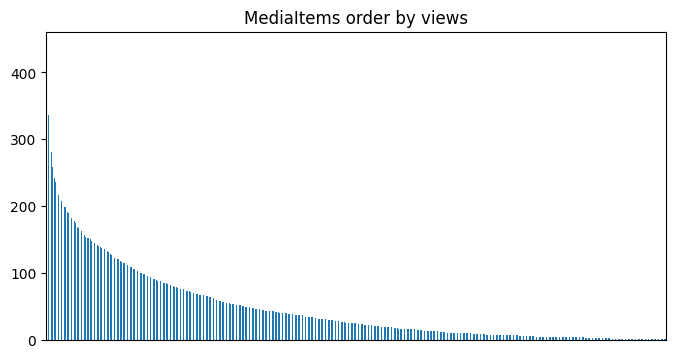

In [58]:
# Many media items distribution has a relatively long tale.
# Useful if one wants to increase diversity.
_, ax = plt.subplots(figsize=(8, 4))
item_freq.sort_values('n_views', ascending=False)['n_views'].plot.bar(ax=ax, width=.5)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_title('MediaItems order by views');

In [59]:
# Find Lowest and Highest rated media:
mean_rating = df.groupby('MediaId')[['StreamLength']].mean()
# Lowest rated media
lowest_rated = mean_rating['StreamLength'].idxmin()
lowest_rated_MediaId = df.loc[df['MediaId'] == lowest_rated]['MediaId']
print(f'Lowest rated MediaId: {lowest_rated_MediaId.unique()} by {len(lowest_rated_MediaId)} users.')

Lowest rated MediaId: [1063] by 29 users.


In [60]:
# Highest rated media
highest_rated = mean_rating['StreamLength'].idxmax()
highest_rated_MediaId = df.loc[df['MediaId'] == highest_rated]['MediaId']
print(f'Lowest rated MediaId: {highest_rated_MediaId.unique()} by {len(highest_rated_MediaId)} users.')

Lowest rated MediaId: [1593] by 1 users.


Text(0.5, 1.0, 'Stream length in minutes')

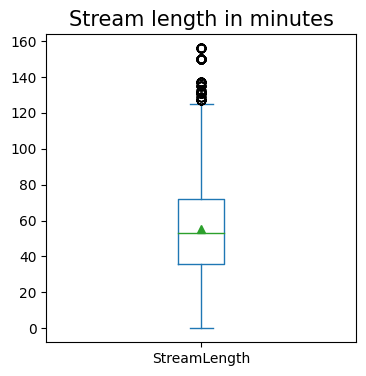

In [61]:
# Outliers are visualized by black circles, indicating that they 
_, ax = plt.subplots(figsize=(4, 4))
df['StreamLength'].plot.box(ax=ax, showmeans=True)
ax.set_title('Stream length in minutes', fontsize=FONTSIZE)

# Processing ratings

In [62]:
stats = df['StreamLength'].describe()
stats

count    78799.000000
mean        55.154190
std         26.025976
min          0.000000
25%         36.000000
50%         53.000000
75%         72.000000
max        156.000000
Name: StreamLength, dtype: float64

In [63]:
# outliers can happen due to errors in data collection
# they can also distort the similarity computation

# Calculate the boundaries for outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
df = df[(df['StreamLength'] >= lower_bound) & (df['StreamLength'] <= upper_bound)]

In [64]:
df = df.rename(columns={"StreamLength": "Rating"})

Text(0.5, 1.0, 'Rating')

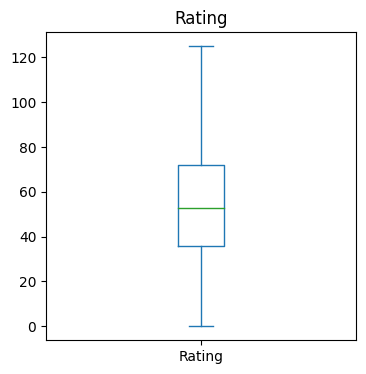

In [66]:
_, ax = plt.subplots(figsize=(4, 4))
df["Rating"].plot.box(ax=ax)
ax.set_title("Rating")

# Item-to-item collaborative filter
A kNN will be used to find similar items based on the ratings from users.

👆 Note that kNN requires to store the item-user matrix, which can take up a lot of memory.

In [67]:
# We need a mapper
print(df["UserId"].max(), len(df["UserId"].unique()))
print(df["MediaId"].max(), len(df["MediaId"].unique()))

943 943
1682 1671


In [68]:
def create_matrix(df: pd.DataFrame):
    """
    Create compressed Sparse Row matrix with M-item-rows and N-user-columns.
    Media and User mappers are used to map id's to indices.
    params: pd.DataFrame
    returns: scipy.sparse.csr_matrix for the compressed matrix, and the mappings (dict)
    """
    N = len(df['UserId'].unique())
    M = len(df['MediaId'].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["UserId"]), list(range(N))))
    media_mapper = dict(zip(np.unique(df["MediaId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["UserId"])))
    media_inv_mapper = dict(zip(list(range(M)), np.unique(df["MediaId"])))

    user_index = [user_mapper[i] for i in df['UserId']]
    media_index = [media_mapper[i] for i in df['MediaId']]

    X = csr_matrix((df["Rating"], (media_index, user_index)), shape=(M, N))

    return X, user_mapper, media_mapper, user_inv_mapper, media_inv_mapper

Note, Ball Trees as the algorithm to structure the input data, are suitable for high-dimensional data and more efficient than brute force.

In [69]:
def get_dimension_reduction_model(X, k, metric='cosine'):
    """
    Trains a k-nearest neighbors algorithm to reduce the dimension of csr matrix.
    """
    k += 1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    return kNN

In [70]:
k = 10

X, user_mapper, media_mapper, user_inv_mapper, media_inv_mapper = create_matrix(df)
model = get_dimension_reduction_model(X, k)

# These are required to find similiar items.
model.media_mapper = media_mapper
model.media_inv_mapper = media_inv_mapper

In [71]:
joblib.dump(model, 'final_model.joblib')

['final_model.joblib']